In [42]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision import transforms

import support.download_data
import support.load_data

path_to_data = "support/data"

## optional random seed
SEED = 42
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(SEED)

# Download the dataset

Download the dataset if it is not already present in the specified path.

In [11]:
# support.download_data.download_and_extract_zip(path_to_data) # uncomment to download the dataset

Extracted files to: support/data


# Load Dataset

Call the custom loader to load the images into a torch.DataLoader object. 

In [17]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),    # Resize the image to 128x128 for lighter computation
    transforms.ToTensor(),
])

batch_size = 32

_, test_loader, train_dataset, test_dataset = support.load_data.load_dataset(
    path_to_data, transform=transform, batch_size=batch_size)


# Filter for class 0 ("good") for CAE training
target_class = 0
filtered_indices = [i for i, (_, label) in enumerate(train_dataset) if label == target_class]
train_dataset = Subset(train_dataset, filtered_indices)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# Setup CAE Model (Encoder + Decoder = Autoencoder)

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 16 * 16, 256)

    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(256, 128 * 16 * 16)
        self.unflatten = nn.Unflatten(1, (128, 16, 16))

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = self.unflatten(x)
        x = self.decoder(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the autoencoder

In [6]:
autoencoder = Autoencoder()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = autoencoder.to(device)

# Define loss function and optimizer

In [7]:
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

def mse_loss_with_variance_regularization(reconstructed, original, encoded, lambda_reg=0.1):
    mse_loss = nn.MSELoss()(reconstructed, original)
    encoded_variance = torch.var(encoded.view(encoded.size(0), -1), dim=1).mean()
    reg_loss = lambda_reg * encoded_variance
    total_loss = mse_loss + reg_loss
    return total_loss

# Safe training checkpoints method

In [14]:
def save_checkpoint(model, optimizer, epoch, filename):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint, filename)

def load_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    epoch = checkpoint['epoch']
    print(f"Checkpoint loaded: epoch {epoch}")
    return epoch

# Train the model

In [9]:
lambda_reg = 0.1  # Regularization strength

number_of_epochs = 2
epoch_losses = []

for epoch in range(number_of_epochs):
    autoencoder.train()

    running_loss = 0.0

    for inputs, _ in train_loader:
        inputs = inputs.to(device)

        reconstructed = autoencoder(inputs)
        encoded = autoencoder.encoder(inputs)

        loss = mse_loss_with_variance_regularization(reconstructed, inputs, encoded, lambda_reg)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)

    save_checkpoint(autoencoder, optimizer, epoch, f'cae_epoch_{epoch}.pth')

    print(f'Epoch [{epoch+1}/{number_of_epochs}], Loss: {avg_loss:.4f}')

Epoch [1/2], Loss: 0.0233
Epoch [2/2], Loss: 0.0203


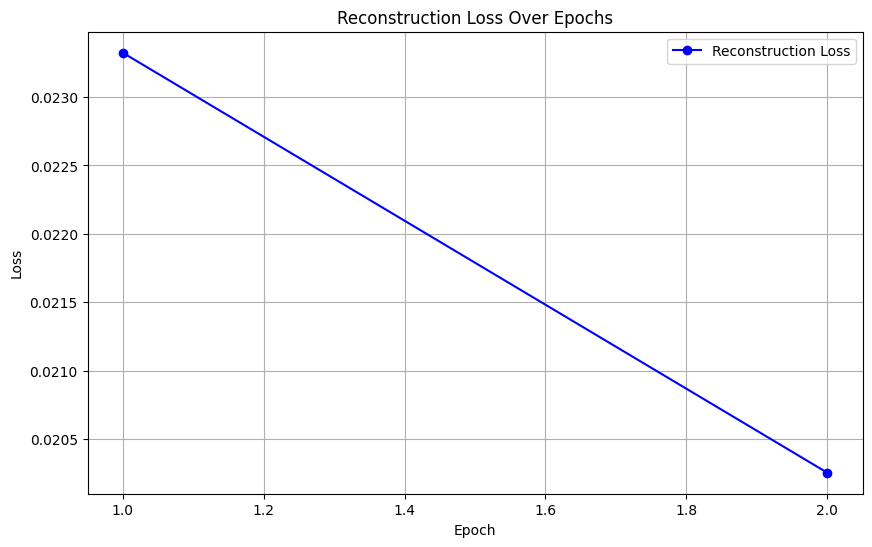

In [11]:
# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, number_of_epochs + 1), epoch_losses, marker='o', color='b', label='Reconstruction Loss')
plt.title('Reconstruction Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# Test the model

## Load the saved model (optional - if you want to test a past model or a specific epoch) 

In [16]:
# Load saved CAE model

autoencoder_checkpoint_path = "cae_epoch_0.pth"
cae = Autoencoder().to(device)
epoch = load_checkpoint(model=cae, optimizer=optimizer, checkpoint_path=autoencoder_checkpoint_path)

Checkpoint loaded: epoch 0


## Plot reconstructed images with error heatmaps

In [23]:
# Plot original, reconstruction, error heatmap for random good images from dataloader
def visualize_autoencoder_performance(autoencoder, data_loader, num_samples=5, title_prefix=""):
    autoencoder.eval()
    images, labels = next(iter(data_loader))
    selected_indices = random.sample(range(len(images)), num_samples)
    images = images[selected_indices].to(device)

    with torch.no_grad():
        reconstructions = autoencoder(images)
        errors = torch.abs(images - reconstructions)

    images_np = images.cpu().permute(0, 2, 3, 1).numpy()
    reconstructions_np = reconstructions.cpu().permute(0, 2, 3, 1).numpy()
    errors_np = errors.cpu().permute(0, 2, 3, 1).numpy()

    max_error = errors_np.mean(axis=-1).max()

    fig, axes = plt.subplots(3, num_samples, figsize=(15, 9), gridspec_kw={'width_ratios': [1]*num_samples, 'wspace': 0.3})

    for i in range(num_samples):
        axes[0, i].imshow(images_np[i])
        axes[0, i].set_title(f"{title_prefix} Original")
        axes[0, i].axis("off")

        axes[1, i].imshow(reconstructions_np[i])
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis("off")

        im = axes[2, i].imshow(errors_np[i].mean(axis=-1), cmap="jet", vmin=0, vmax=max_error)
        axes[2, i].set_title("Error Heatmap")
        axes[2, i].axis("off")

    cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
    fig.colorbar(im, cax=cbar_ax, label="Reconstruction Error")

    plt.show()


Visualizing training data:


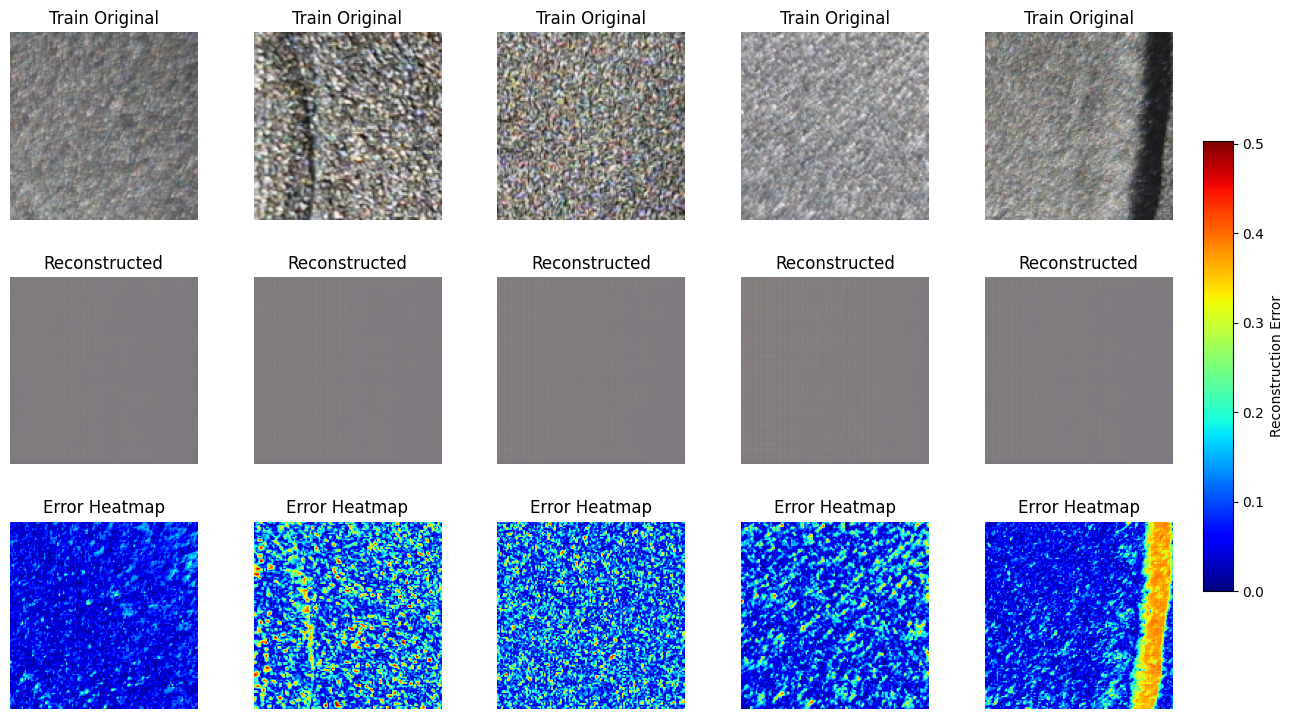

Visualizing good test data:


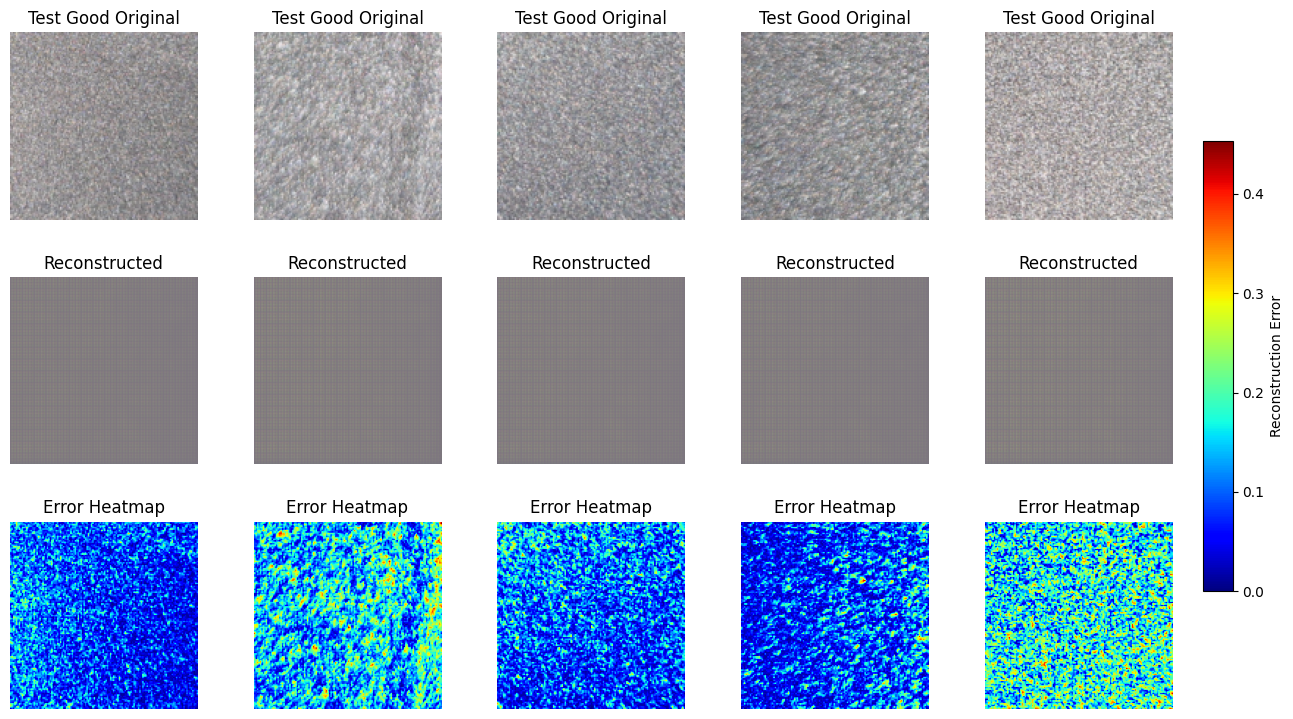

Visualizing bad test data:


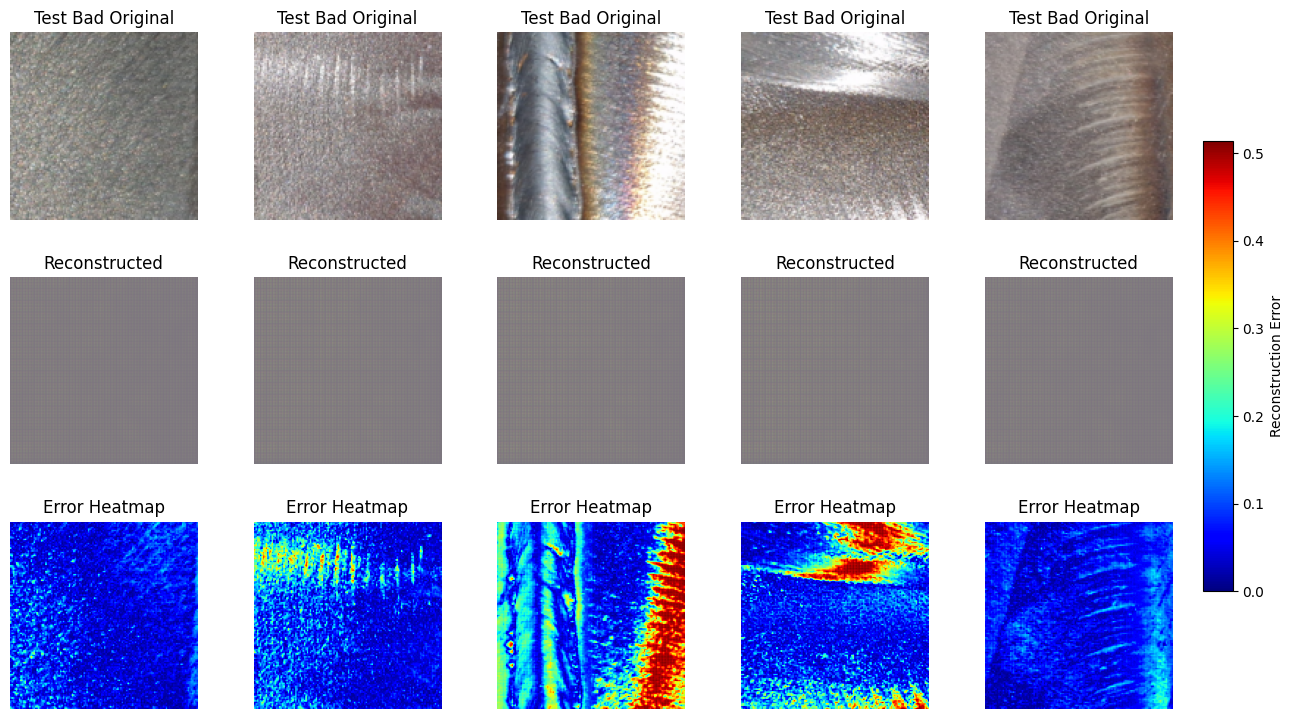

In [24]:
print("Visualizing training data:")
visualize_autoencoder_performance(cae, train_loader, num_samples=5, title_prefix="Train")

print("Visualizing good test data:")
visualize_autoencoder_performance(cae, test_loader, num_samples=5, title_prefix="Test Good")

print("Visualizing bad test data:")
test_bad_loader = DataLoader(
    Subset(test_dataset, [i for i, (_, label) in enumerate(test_dataset) if label != target_class]),
    batch_size=batch_size,
    shuffle=False
)
visualize_autoencoder_performance(cae, test_bad_loader, num_samples=5, title_prefix="Test Bad")

## Classification

In [25]:
def compute_threshold(features_train, C):
    V_mean = features_train.mean(dim=0)
    distances = torch.norm(features_train - V_mean, dim=1)
    mu_d = distances.mean()
    sigma_d = distances.std()
    Td = mu_d + C * sigma_d
    return Td, V_mean


In [26]:
# Extract Features from Training Data
print("Extracting features from training data...")
features_train = []
with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)
        features = cae.encoder(images)
        features = features.view(features.size(0), -1)
        features_train.append(features)
features_train = torch.cat(features_train, dim=0)

# Control Limit Constant
C = 0.01

# Compute Threshold
Td, V_mean = compute_threshold(features_train, C)
print(f"Threshold (Td): {Td:.4f}")

Extracting features from training data...
Threshold (Td): 0.1555


In [27]:
def evaluate_model(test_loader, cae, V_mean, Td, device):
    # Get predictions
    y_true = []
    y_pred = []

    cae.eval()
    with torch.no_grad():
        for images, labels_batch in test_loader:
            images = images.to(device)
            labels_batch = labels_batch.to(device)

            features = cae.encoder(images).view(images.size(0), -1)

            for i in range(features.size(0)):
                dI = torch.norm(features[i] - V_mean)
                prediction = 1 if dI > Td else 0
                y_pred.append(prediction)
                y_true.append(labels_batch[i].item())

    # Calculate overall metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)

    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

    # Calculate metrics per class
    categories = ['Ready for Paint', 'Needs Shot Blasting']

    precision_list = []
    recall_list = []
    f1_list = []

    for label in [0, 1]:
        precision_class = precision_score(y_true, y_pred, labels=[label], average='binary', pos_label=label, zero_division=0)
        recall_class = recall_score(y_true, y_pred, labels=[label], average='binary', pos_label=label, zero_division=0)
        f1_class = f1_score(y_true, y_pred, labels=[label], average='binary', pos_label=label, zero_division=0)

        precision_list.append(precision_class)
        recall_list.append(recall_class)
        f1_list.append(f1_class)

    results_table = pd.DataFrame({
        'Category': categories,
        'Precision': precision_list,
        'Recall': recall_list,
        'F1-Score': f1_list
    })

    accuracy_row = pd.DataFrame({'Category': ['Accuracy'], 'Precision': [""], 'Recall': [""], 'F1-Score': [accuracy]})
    results_table = pd.concat([results_table, accuracy_row], ignore_index=True)

    return metrics, results_table

In [30]:
metrics, results_table = evaluate_model(test_loader, cae, V_mean, Td, device)

print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")

print(results_table)

Accuracy: 0.5680
Precision: 0.5154
Recall: 0.5982
F1 Score: 0.5537
              Category Precision    Recall  F1-Score
0      Ready for Paint     0.625  0.543478  0.581395
1  Needs Shot Blasting  0.515385  0.598214  0.553719
2             Accuracy                      0.568000


In [38]:
def evaluate_model(test_loader, cae, V_mean, Td, device, num_samples=5):
    cae.eval()
    counter = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            reconstructions = cae(images)
            features = cae.encoder(images).view(images.size(0), -1)

            for i in range(images.size(0)):
                if counter >= num_samples:
                    return
                counter += 1
                dI = torch.norm(features[i] - V_mean)
                prediction = 1 if dI > Td else 0

                original = images[i].cpu().numpy().transpose(1, 2, 0)
                reconstructed = reconstructions[i].cpu().numpy().transpose(1, 2, 0)
                error_map = np.abs(original - reconstructed).mean(axis=2)

                if labels[i] == 1 and prediction == 1:
                    classification = "True Positive (TP)"
                elif labels[i] == 0 and prediction == 1:
                    classification = "False Positive (FP)"
                elif labels[i] == 1 and prediction == 0:
                    classification = "False Negative (FN)"
                else:
                    classification = "True Negative (TN)"

                fig, ax = plt.subplots(1, 3, figsize=(12, 4))
                fig.suptitle(classification, fontsize=14)

                ax[0].imshow(original, cmap='gray')
                ax[0].set_title("Original")
                ax[0].axis("off")

                ax[1].imshow(reconstructed, cmap='gray')
                ax[1].set_title("Reconstruction")
                ax[1].axis("off")

                ax[2].imshow(error_map, cmap='jet')
                ax[2].set_title("Error Map")
                ax[2].axis("off")

                plt.show()

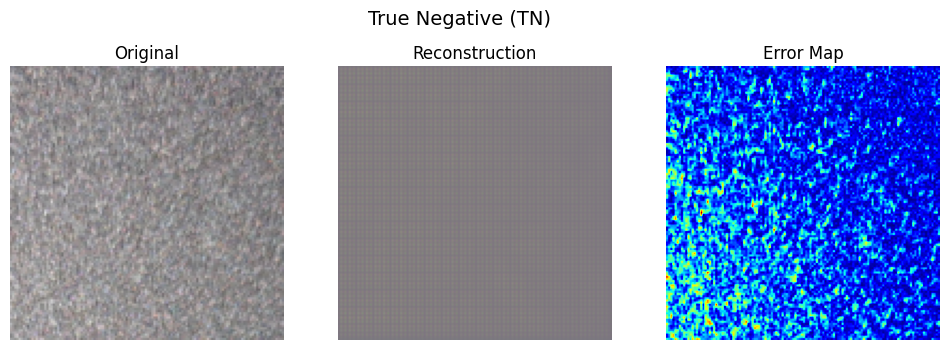

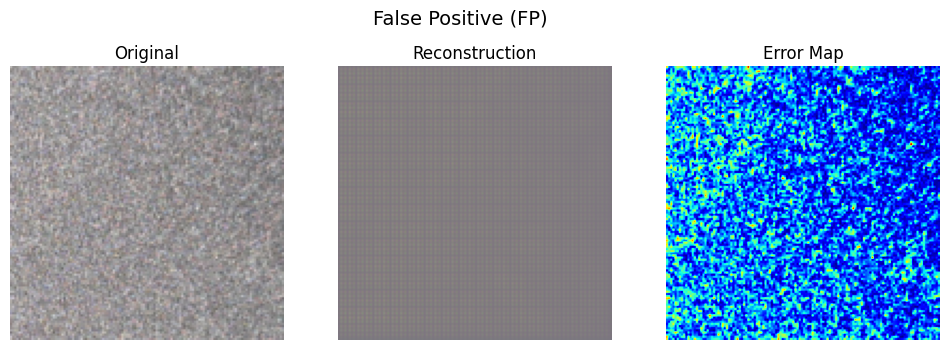

In [41]:
evaluate_model(test_loader, cae, V_mean, Td, device, num_samples=2)